<a href="https://colab.research.google.com/github/palVikram/Advance_tensorflow/blob/main/Image_Classification_and_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [3]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu) # Going back and forth between TPU and host is expensive. Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


Loading and Preprocessing the Dataset
Define some helper functions that will pre-process your data:

read_image_tfds: randomly overlays the "digit" image on top of a larger canvas.
get_training_dataset: loads data and splits it to get the training set.
get_validation_dataset: loads and splits the data to get the validation set.

In [4]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync

In [5]:

'''
Transforms each image in dataset by pasting it on a 75x75 canvas at random locations.
'''
def read_image_tfds(image, label):
    xmin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    ymin = tf.random.uniform((), 0 , 48, dtype=tf.int32)
    image = tf.reshape(image, (28,28,1,))
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)
    image = tf.cast(image, tf.float32)/255.0
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)
   
    xmax = (xmin + 28) / 75
    ymax = (ymin + 28) / 75
    xmin = xmin / 75
    ymin = ymin / 75
    return image, (tf.one_hot(label, 10), [xmin, ymin, xmax, ymax])
  
'''
Loads and maps the training split of the dataset using the map function. Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
'''
def get_training_dataset():
      
      with  strategy.scope():
        dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
        dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat() # Mandatory for Keras for now
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
        dataset = dataset.prefetch(-1)  # fetch next batches while training on the current one (-1: autotune prefetch buffer size)
      return dataset

'''
Loads and maps the validation split of the dataset using the map function. Note that we try to load the gcs version since TPU can only work with datasets on Google Cloud Storage.
'''  
def get_validation_dataset():
    dataset = tfds.load("mnist", split="test", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)

    #dataset = dataset.cache() # this small dataset can be entirely cached in RAM
    dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
    dataset = dataset.repeat() # Mandatory for Keras for now
    return dataset

# instantiate the datasets
with strategy.scope():
  training_dataset = get_training_dataset()
  validation_dataset = get_validation_dataset()

In [6]:
def final_model(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75, 75, 1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
    feature_cnn = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Flatten()(feature_cnn)
    dense_output = tf.keras.layers.Dense(128, activation='relu')(x)

    classification_output =   classification_output = tf.keras.layers.Dense(10, activation='softmax', name = 'classification')(dense_output)
    bounding_box_output = bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])

    return model
  

def define_and_compile_model(inputs):
  model = final_model(inputs)
  
  model.compile(optimizer='adam', 
              loss = {'classification' : 'categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : 'mse'
                        })
  return model

    
with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(75, 75, 1,))
  model = define_and_compile_model(inputs)

# print model layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 73, 73, 16)   160         ['input_1[0][0]']                
                                                                                                  
 average_pooling2d (AveragePool  (None, 36, 36, 16)  0           ['conv2d[0][0]']                 
 ing2D)                                                                                           
                                                                                                  
 conv2d_1 (Conv2D)              (None, 34, 34, 32)   4640        ['average_pooling2d[0][0]']  

In [7]:
EPOCHS = 10 # 45
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

loss, classification_loss, bounding_box_loss, classification_accuracy, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", classification_accuracy)

Epoch 1/10
937/937 [==============================] - 239s 251ms/step - loss: 0.9503 - classification_loss: 0.9335 - bounding_box_loss: 0.0168 - classification_accuracy: 0.6778 - bounding_box_mse: 0.0168 - val_loss: 0.2870 - val_classification_loss: 0.2767 - val_bounding_box_loss: 0.0103 - val_classification_accuracy: 0.9165 - val_bounding_box_mse: 0.0103
Epoch 2/10
937/937 [==============================] - 304s 324ms/step - loss: 0.2619 - classification_loss: 0.2553 - bounding_box_loss: 0.0066 - classification_accuracy: 0.9228 - bounding_box_mse: 0.0066 - val_loss: 0.2147 - val_classification_loss: 0.2099 - val_bounding_box_loss: 0.0048 - val_classification_accuracy: 0.9357 - val_bounding_box_mse: 0.0048
Epoch 3/10
937/937 [==============================] - 293s 312ms/step - loss: 0.1901 - classification_loss: 0.1864 - bounding_box_loss: 0.0037 - classification_accuracy: 0.9428 - bounding_box_mse: 0.0037 - val_loss: 0.1342 - val_classification_loss: 0.1314 - val_bounding_box_loss: 0.

In [9]:
# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

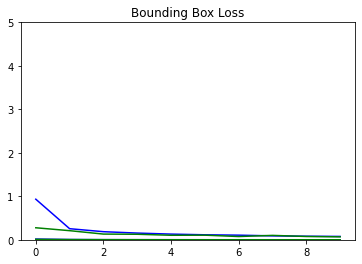

In [10]:
plot_metrics("classification_loss", "Classification Loss")
plot_metrics("bounding_box_loss", "Bounding Box Loss")

In [11]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area
    
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

In [13]:
# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      validation_bboxes = validation_bboxes.numpy()
      break
    for training_digits, (training_labels, training_bboxes) in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      training_bboxes = training_bboxes.numpy()
      break
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels, training_bboxes,
          validation_digits, validation_labels, validation_bboxes)

In [15]:
(training_digits, training_labels, training_bboxes,
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)


In [16]:
# recognize validation digits
predictions = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(predictions[0], axis=1)

predicted_bboxes = predictions[1]

iou = intersection_over_union(predicted_bboxes, validation_bboxes)

iou_threshold = 0.6

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))


Number of predictions where iou > threshold(0.6): 9373
Number of predictions where iou < threshold(0.6): 627


In [18]:
# utility to display a row of digits with their predictions
import draw_boxes
draw_boxes.display_digits_with_boxes(validation_digits, predicted_labels, validation_labels, predicted_bboxes, validation_bboxes, iou, "True and Predicted values")

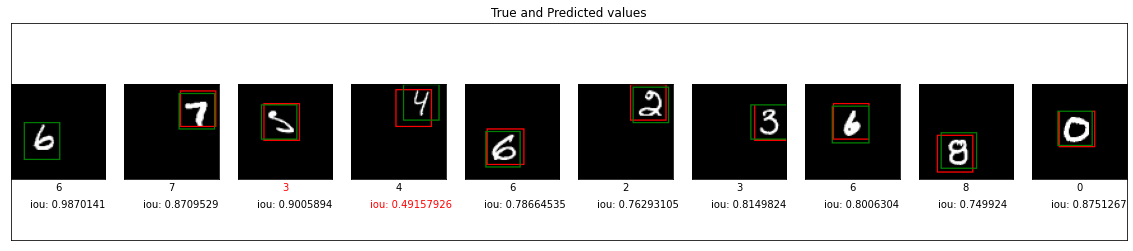

In [ ]:
Reference: https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow/ungradedLab/Zgt6D/image-classification-and-object-localization